Go directly to:
- [**Start page**](https://github.com/coconeuro/remeta/)
- [**Installation**](https://github.com/coconeuro/remeta/blob/main/INSTALL.md)
- [**Basic Usage** (this page)](https://github.com/coconeuro/remeta/blob/main/demo/basic_usage.ipynb)
- [**Common use cases**](https://github.com/coconeuro/remeta/blob/main/demo/common_use_cases.ipynb)
- [**Group estimation and priors**](https://github.com/coconeuro/remeta/blob/main/demo/group_estimation_priors.ipynb)

## Basic usage

In this section, the essential settings to run a ReMeta analysis are introduced.

In [33]:
import numpy as np
import remeta

np.random.seed(0)  # make notebook reproducible

To specify the model, we use the `Configuration` object:

In [34]:
cfg = remeta.Configuration()

In [35]:
cfg.param_type1_noise.enable = 2

#### Simulate data
To test the model, we first simulate data from a generative model that is based on the model specification above. For such an exercise, the toolbox has a method `simu_data()` which takes the `Configuration` instance as input. In addition, we have to specify the value of each parameter. The parameter names can be inferred from the `enable_XYZ` settings:

In [36]:
params_true = dict(
    type1_noise=[0.5, 0.7],
    type1_bias=-0.1,
    type2_noise=0.1,
    type2_criteria=[0.25, 0.5, 0.75],
)

Note that we defined `type1_noise` as a list, such that `type1_noise[0]` and `type1_noise[1]` correspond to the type 1 noise for the negative and positive stimulus category, respectively.

Type 2 criteria are likewise defined as a list, although caution is required, as only the first entry can be interpreted as an absolute criterion, whereas the subsequent entries specify the distance to the respective previous criterion. Thus, the absolute criteria in this case are `[0.2, 0.4, 0.6, 0.8]`. These are the optimal criteria to divide the confidence space (range 0-1) into 5 bins of equal size (note the default setting `cfg.n_discrete_confidence_levels=5`).

To illustrate the next steps, we simulate data with the above parameters.

In [37]:
data = remeta.simulate(params=params_true, squeeze=True, stim_levels=4, cfg=cfg)

----------------------------------
..Generative model:
    Type 1 noise distribution: normal
    Type 2 noise type: report
    Type 2 noise distribution: beta_mode
..Generative parameters:
    type1_noise: [0.5 0.7]
    type1_bias: -0.1
    type2_noise: 0.1
    type2_criteria: [0.25 0.5  0.75]
        [extra] Criterion bias: 0.0000
        [extra] Criterion-based confidence bias: 0.0000
..Descriptive statistics:
    No. subjects: 1
    No. samples: 1000
    Accuracy: 82.8% correct
    d': 2.0
    Choice bias: -6.2%
    Confidence: 0.57
    M-Ratio: 0.66
    AUROC2: 0.69
----------------------------------


#### Visualizing the simulated data

Let's take a look at the psychometric curve:

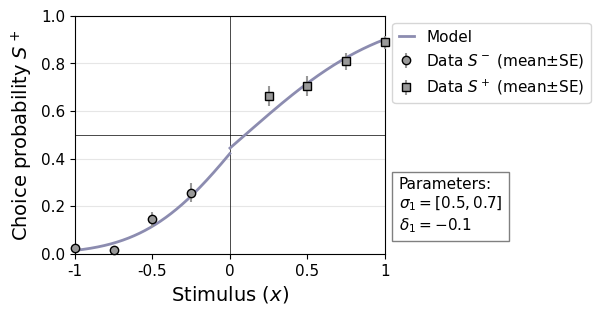

In [38]:
data.plot_psychometric(model_prediction=True);

Note that the purple line is not a fit, but an (augmented) logistic function based on the true parameters. At zero, there is a discontinuity due the different type 1 noise parameters for stimulus > 0 and stimulus < 0. Moreover, the curve is shifted towards a preference for the negative stimulus category ($S^-$) due to the negative type 1 bias parameter ($S^-$ and $S^+$ are the two stimulus categories).

Next, we plot the relationship between stimulus intensity and confidence:

model_prediction=True


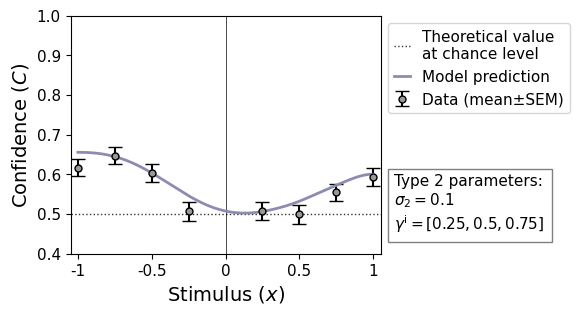

In [39]:
data.plot_stimulus_versus_confidence(model_prediction=True)

We can see that the confidence slope for negative stimuli is a bit steeper. This is because we had introduced an assymmetry in the type 1 noise between the positive and the negative stimulus category. Since we further assume an observer that computes Bayesian confidence (i.e. probability correct) based on an estimate of type 1 noise, confidence appears more 'sensitive' for the negative stimulus category (remember that we set _lower_ type 1 noise for the stimulus category $S^-$ relative to the stimulus category $S^+$).

#### Model fit
We now need to create an instance of ReMeta. Note that for illustratory purposes we pass the true parameters to the configuration as well, for later comparison.

In [40]:
cfg.true_params = params_true
cfg.optim_type2_gridsearch = False  # we deactivate costly gridsearch for this demo
rem = remeta.ReMeta(cfg=cfg)

Now, everything is in place to fit the model to the simulated data. The fit function takes three main arguments: the stimuli (ideally in the range -1 to 1), the choices (coded as 0/1 or -1/1) and confidence ratings (normalized to the range 0..1).

In [41]:
rem.fit(data.stimuli, data.choices, data.confidence)

Dataset characteristics:
    No. subjects: 1
    No. samples: 1000
    Accuracy: 82.8% correct
    d': 1.952
    Choice bias: -6.2%
    Mean confidence: 0.566 (min: 0.125, max: 0.875)

+++ Type 1 level +++
  Subject-level estimation (MLE)
    .. finished (0.1 secs).
  Final report
    Parameters estimates (subject-level fit)
        [subject] type1_noise: [0.442 ± 0.055, 0.824 ± 0.099] (true: [0.500, 0.700])
        [subject] type1_bias: -0.011 ± 0.062 (true: -0.100)
    [subject] Log-likelihood: -411.03 (per sample: -0.411)
    [subject] Fitting time: 0.09 secs
    Log-likelihood using true params: -412.14 (per sample: -0.4121)
Type 1 level finished

+++ Type 2 level +++
  Subject-level estimation (MLE)
    .. finished (32.8 secs).
  Final report
    Parameters estimates (subject-level fit)
        [subject] type2_noise: 0.090 ± 0.017 (true: 0.100)
        [subject] type2_criteria: [0.260 ± 0.014, 0.537 ± 0.019, 0.782 ± 0.018] (true: [0.250, 0.500, 0.750])
            [extra] type2_cr

#### Inspecting the model fit

Obtain the fitting result:

In [42]:
result = rem.summary()

We've seen the estimated parameters already printed above, but they are also stored in the result object:

In [43]:
for k, v in result.type1.params.items():
    print(f'{k}: {np.array2string(np.array(v), precision=3)}')


type1_noise: [0.442 0.824]
type1_bias: -0.011


In [44]:
result.type1.loglik_true

np.float64(-412.136421070236)

Given that the original parameter were `type1_noise=[0.5, 0.7]` and `type1_bias=-0.1`, this is not too bad. We have recovered the original parameters to some approximation. Nevertheless, the fitted parameters do not _exactly_ match our generative parameters. Since we passed the true parameters, the result object allows us to check whether this is because the optimization routine did not find the global minimum. We can find out by comparing the log likelihood the true and fitted parameters:

In [45]:
print(f"Log-likelihood of true type 1 parameters: {result.type1.loglik_true:.2f}")
print(f"Log-likelihood of fitted type 1  parameters: {result.type1.loglik:.2f}")

Log-likelihood of true type 1 parameters: -412.14
Log-likelihood of fitted type 1  parameters: -411.03


The log-likelihood is higher for the fitted parameters and thus we can be confident in the obtained parameters.

Next, we take a look at the metacognitive "type 2" parameters:

In [46]:
for k, v in result.type2.params.items():
    print(f'{k}: {np.array2string(np.array(v), precision=3)}')


type2_noise: 0.09
type2_criteria: [0.26  0.537 0.782]


Note that our original parameters were `type2_noise=0.2`, `type2_criteria=[0.2, 0.4, 0.6, 0.8]`, so this is close.

In [47]:
print(f"Log-likelihood of true type 2 parameters: {result.type2.loglik_true:.2f}")
print(f"Log-likelihood of fitted type 2  parameters: {result.type2.loglik:.2f}")

Log-likelihood of true type 2 parameters: -1705.70
Log-likelihood of fitted type 2  parameters: -1701.90


Again, the log-likelihood is slightly better (i.e., higher) for the fitted parameters.

#### Visualization of the model fit

Having fit the model, we can now visualize confidence (based on the data and the fitted model) as a function of sensory decision values. For this purpose, a fitted `ReMeta` instance has a method called `plot_evidence_versus_confidence()`:

model_prediction=True


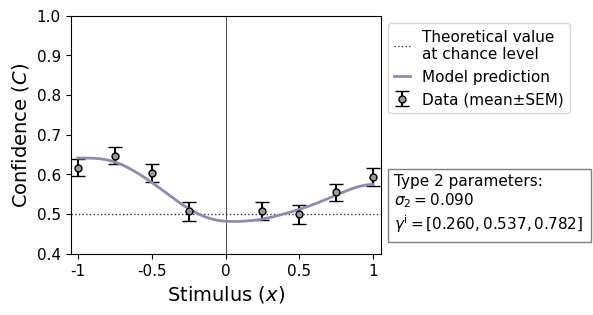

In [48]:
rem.plot_stimulus_versus_confidence(model_prediction=True)

The large overlap between data- and model-based confidence ratings is of course not surprising, since the data were generated with a model of identical architecture and parameters.